## Policy Lapse Prediction
## Data used for analysis is based on Integral Life Admin System

### The SQL query in below cells will retreive data based on database credentials provide. Right now these credentials have been left empty for security reasons. Please enter relevant details before running this notebook further.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# For Normalization
from sklearn.preprocessing import MinMaxScaler

# For Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')


C:\Users\aaacharya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import Data

In [2]:
# Enter ip address and port number of the system where the database resides.
server = '20.198.58.32' 
database = 'INT77DB2014'  
username = 'boadmin' 
password = 'BoAdmin12#$'

In [3]:
# Add appropriate driver name
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [4]:
# Run Query
query = '''
SELECT 
CHDR.CHDRNUM AS 'POLICY_NUMBER',
CLNT.CLNTNUM AS 'CLIENT_NUMBER',
RTRIM(STATCODE_DESC.LONGDESC) + '-' + LTRIM(CHDR.STATCODE) AS 'POLICY_STATUS',
CASE
WHEN 
CHDR.STATCODE = 'LA'
THEN 
'1'
ELSE
'0'
END AS 'LAPSE_INDICATOR',
CASE 
WHEN 
CLNT.CLTSEX = 'F'
THEN 
'1'
ELSE
'0'
END AS 'FEMALE',
CASE 
WHEN 
CLNT.CLTSEX = 'M'
THEN 
'1'
ELSE
'0'
END AS 'MALE',
CASE 
WHEN 
CLNT.CLTSEX = ''
THEN 
'1'
ELSE
'0'
END AS 'GENDER_UNKNOWN',
CASE 
WHEN 
CLNT.MARRYD = 'M'
THEN 
'1'
ELSE
'0'
END AS 'MARRIED',
CASE 
WHEN 
CLNT.MARRYD = 'D'
THEN 
'1'
ELSE
'0'
END AS 'DIVORCED',
CASE 
WHEN 
CLNT.MARRYD = 'S'
THEN 
'1'
ELSE
'0'
END AS 'SINGLE',
CASE 
WHEN 
CLNT.MARRYD IN ('J', 'L', 'C', 'Z')
THEN 
'1'
ELSE
'0'
END AS 'MARITAL_STATUS_UNKNOWN',
CASE
WHEN
LIFE.OCCUP = '' OR LIFE.OCCUP IS NULL
THEN
'PROF_UNKNOWN'
ELSE
RTRIM(T3644.LONGDESC)
END  AS 'PROFESSION',
CASE
WHEN LIFE.ANBCCD BETWEEN 0 AND 14
THEN 
'1'
ELSE
'0' 
END AS 'CHILD',
CASE
WHEN LIFE.ANBCCD BETWEEN 15 AND 24
THEN 
'1'
ELSE
'0' 
END AS 'YOUTH',
CASE
WHEN LIFE.ANBCCD BETWEEN 25 AND 64
THEN 
'1'
ELSE
'0' 
END AS 'ADULT',
CASE
WHEN LIFE.ANBCCD > 65 
THEN 
'1'
ELSE
'0' 
END AS 'SENIOR_CITIZEN',
CASE
WHEN
LIFE.SMOKING = 'N'
THEN
'1'
ELSE
'0'
END AS 'NON_SMOKER',
CASE
WHEN
LIFE.SMOKING <> 'N'
THEN
'1'
ELSE
'0'
END AS 'SMOKER',
CASE 
WHEN
UNDL.BMI < 18.5
THEN
'1'
ELSE
'0'
END AS 'UNDER_WEIGHT',
CASE 
WHEN
UNDL.BMI BETWEEN 18.5 AND 24.9
THEN
'1'
ELSE
'0'
END AS 'NORMAL_WEIGHT',
CASE 
WHEN
UNDL.BMI BETWEEN 25 AND 29.9
THEN
'1'
ELSE
'0'
END AS 'OVER_WEIGHT',
CASE 
WHEN
UNDL.BMI > 30
THEN
'1'
ELSE
'0'
END AS 'OBESE',

(COALESCE(QQ.[01],0) + COALESCE(QQ.[02],0) + COALESCE(QQ.[03],0)) AS Q1_BUY, 
(COALESCE(QQ.[04],0) + COALESCE(QQ.[05],0) + COALESCE(QQ.[06],0)) AS Q2_BUY, 
(COALESCE(QQ.[07],0) + COALESCE(QQ.[08],0) + COALESCE(QQ.[09],0)) AS Q3_BUY, 
(COALESCE(QQ.[10],0) + COALESCE(QQ.[11],0) + COALESCE(QQ.[12],0)) AS Q4_BUY


FROM
(SELECT CLNTNUM, VALIDFLAG, CLTSEX, MARRYD FROM VM1DTA.CLNTPF WHERE VALIDFLAG = '1') CLNT 
INNER JOIN 
(
SELECT DISTINCT CH1.CHDRNUM, CH1.COWNNUM, CH1.STATCODE
FROM
(SELECT DISTINCT CHDRCOY, CHDRNUM, COWNNUM, STATCODE,TRANNO  FROM VM1DTA.CHDRPF WHERE CHDRCOY = '2' and VALIDFLAG = '1')CH1
INNER JOIN
(SELECT CHDRNUM, MAX(TRANNO) AS MAX_TRANNO FROM VM1DTA.CHDRPF WHERE CHDRCOY = '2' and VALIDFLAG = '1' GROUP BY CHDRNUM )CH2
ON CH2.CHDRNUM=CH1.CHDRNUM AND CH2.MAX_TRANNO=CH1.TRANNO
) CHDR 
ON CHDR.COWNNUM = CLNT.CLNTNUM
LEFT OUTER JOIN
(SELECT DESCITEM, LONGDESC FROM VM1DTA.DESCPF WHERE LANGUAGE = 'E' AND DESCCOY ='2' AND DESCTABL = 'T3623') STATCODE_DESC
ON STATCODE_DESC.DESCITEM = CHDR.STATCODE
LEFT OUTER JOIN 
(SELECT LIFE01.CHDRNUM, LIFE01.VALIDFLAG, LIFE01.LIFE, LIFE01.JLIFE, LIFE01.LIFCNUM, LIFE01.OCCUP, LIFE01.SMOKING, LIFE01.ANBCCD
FROM
(SELECT * FROM VM1DTA.LIFEPF LIFE01) LIFE01 
INNER JOIN 
(SELECT LIFCNUM, MAX(UNIQUE_NUMBER) AS MAX_UNIQUE_NUMBER FROM VM1DTA.LIFEPF GROUP BY LIFCNUM) LIFE02 
ON LIFE01.LIFCNUM = LIFE02.LIFCNUM AND LIFE01.UNIQUE_NUMBER = LIFE02.MAX_UNIQUE_NUMBER ) LIFE
ON LIFE.LIFCNUM = CLNT.CLNTNUM
LEFT OUTER JOIN
VM1DTA.DESCPF T3644
ON T3644.DESCITEM = LIFE.OCCUP AND T3644.DESCTABL = 'T3644' AND T3644.LANGUAGE = 'E' AND T3644.DESCCOY = '9' AND T3644.DESCPFX = 'IT'
INNER JOIN 
VM1DTA.UNDLPF UNDL
ON UNDL.CHDRNUM = LIFE.CHDRNUM AND UNDL.LIFE = LIFE.LIFE AND UNDL.JLIFE = LIFE.JLIFE
INNER JOIN
(SELECT *
FROM
(
  SELECT DISTINCT COWNNUM, COUNT(DISTINCT CHDRNUM) AS COUNTING,SUBSTRING((CAST(OCCDATE AS CHAR)),5,2) AS QQ FROM VM1DTA.CHDRPF WHERE CHDRCOY = '2' and VALIDFLAG = '1' 
  GROUP BY COWNNUM, SUBSTRING((CAST(OCCDATE AS CHAR)),5,2)
) AS SOURCETABLE PIVOT( SUM(COUNTING) FOR [QQ] IN([01], [02],[03], [04],[05], [06],[07], [08],[09], [10],[11],
 [12])) AS PIVOTTABLE ) QQ

 ON QQ.COWNNUM = CLNT.CLNTNUM
 
 ORDER BY CLNT.CLNTNUM
'''

In [5]:
# Read data
df_orig = pd.read_sql(query,cnxn)

# Close the cursor
cursor.close() 

In [6]:
# Check data sample
df_orig.head()

,POLICY_NUMBER,CLIENT_NUMBER,POLICY_STATUS,LAPSE_INDICATOR,FEMALE,MALE,GENDER_UNKNOWN,MARRIED,DIVORCED,SINGLE,MARITAL_STATUS_UNKNOWN,PROFESSION,CHILD,YOUTH,ADULT,SENIOR_CITIZEN,NON_SMOKER,SMOKER,UNDER_WEIGHT,NORMAL_WEIGHT,OVER_WEIGHT,OBESE,Q1_BUY,Q2_BUY,Q3_BUY,Q4_BUY
0,00025154,0001529,In Force-IF,0,0,1,0,0,0,0,0,Architect,0,0,1,0,1,0,0,0,0,1,16,0,0,0
1,00025155,0001529,In Force-IF,0,0,1,0,0,0,0,0,Architect,0,0,1,0,1,0,0,0,0,1,16,0,0,0
2,00019874,0001529,Contract Lapsed-LA,1,0,1,0,0,0,0,0,Architect,0,0,1,0,1,0,0,0,0,1,16,0,0,0
3,00027635,0001529,In Force-IF,0,0,1,0,0,0,0,0,Architect,0,0,1,0,1,0,0,0,0,1,16,0,0,0
4,00021321,0001529,In Force-IF,0,0,1,0,0,0,0,0,Architect,0,0,1,0,1,0,0,0,0,1,16,0,0,0


## Data Analysis & Visualization

In [7]:
# Check data shape
df_orig.shape

(11618, 26)

In [8]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11618 entries, 0 to 11617
Data columns (total 26 columns):
POLICY_NUMBER             11618 non-null object
CLIENT_NUMBER             11618 non-null object
POLICY_STATUS             11613 non-null object
LAPSE_INDICATOR           11618 non-null object
FEMALE                    11618 non-null object
MALE                      11618 non-null object
GENDER_UNKNOWN            11618 non-null object
MARRIED                   11618 non-null object
DIVORCED                  11618 non-null object
SINGLE                    11618 non-null object
MARITAL_STATUS_UNKNOWN    11618 non-null object
PROFESSION                11618 non-null object
CHILD                     11618 non-null object
YOUTH                     11618 non-null object
ADULT                     11618 non-null object
SENIOR_CITIZEN            11618 non-null object
NON_SMOKER                11618 non-null object
SMOKER                    11618 non-null object
UNDER_WEIGHT              1

In [9]:
# View distribution of 'Lapse' Instances
df_orig['LAPSE_INDICATOR'].value_counts()

0    10751
1      867
Name: LAPSE_INDICATOR, dtype: int64

In [10]:
# Check if there are any nulls
df_orig.isnull().sum()

POLICY_NUMBER             0
CLIENT_NUMBER             0
POLICY_STATUS             5
LAPSE_INDICATOR           0
FEMALE                    0
MALE                      0
GENDER_UNKNOWN            0
MARRIED                   0
DIVORCED                  0
SINGLE                    0
MARITAL_STATUS_UNKNOWN    0
PROFESSION                0
CHILD                     0
YOUTH                     0
ADULT                     0
SENIOR_CITIZEN            0
NON_SMOKER                0
SMOKER                    0
UNDER_WEIGHT              0
NORMAL_WEIGHT             0
OVER_WEIGHT               0
OBESE                     0
Q1_BUY                    0
Q2_BUY                    0
Q3_BUY                    0
Q4_BUY                    0
dtype: int64

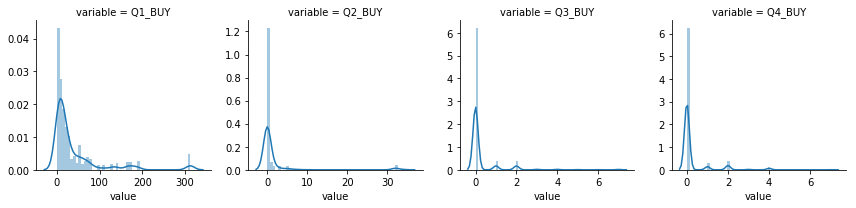

In [11]:
# Study distribution of Numerical Columns
num = [f for f in df_orig.columns if df_orig.dtypes[f] != 'object']
nd = pd.melt(df_orig, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

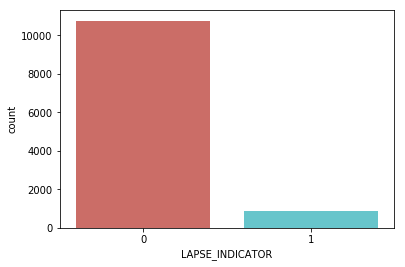

In [12]:
# Plot count values
df_orig.LAPSE_INDICATOR.value_counts()
sns.countplot(x = 'LAPSE_INDICATOR', data = df_orig, palette = 'hls')
plt.show()

## Data Treatment

In [13]:
# Separate features into categorical and numerical category
cat_vars = ['POLICY_STATUS', 'FEMALE', 'MALE', 'GENDER_UNKNOWN', 'MARRIED', 'DIVORCED',
           'SINGLE', 'MARITAL_STATUS_UNKNOWN', 'PROFESSION', 'CHILD', 'YOUTH', 'ADULT', 'SENIOR_CITIZEN', 'NON_SMOKER',
           'SMOKER', 'UNDER_WEIGHT', 'NORMAL_WEIGHT', 'OVER_WEIGHT', 'OBESE']

num_vars = ['Q1_BUY', 'Q2_BUY', 'Q3_BUY']

In [14]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [15]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [16]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [17]:
# Check data shape after dummy encoding
df_work.shape

(11618, 111)

In [18]:
# Remove original columns for which dummy variables have been created
vars_remove = ['POLICY_NUMBER','CLIENT_NUMBER','POLICY_STATUS', 'FEMALE', 'MALE', 'GENDER_UNKNOWN',
               'MARRIED', 'DIVORCED','SINGLE', 'MARITAL_STATUS_UNKNOWN', 'PROFESSION', 'CHILD', 'YOUTH', 'ADULT', 
               'SENIOR_CITIZEN', 'NON_SMOKER', 'SMOKER', 'UNDER_WEIGHT', 'NORMAL_WEIGHT', 'OVER_WEIGHT', 'OBESE']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [19]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Q1_BUY'] = scaler.fit_transform(df_work['Q1_BUY'].values.reshape(-1,1))
df_work['Q2_BUY'] = scaler.fit_transform(df_work['Q2_BUY'].values.reshape(-1,1))
df_work['Q3_BUY'] = scaler.fit_transform(df_work['Q3_BUY'].values.reshape(-1,1))
df_work['Q4_BUY'] = scaler.fit_transform(df_work['Q4_BUY'].values.reshape(-1,1))

In [20]:
# Create separate dataset for feature and target columns
x = df_work.drop('LAPSE_INDICATOR', axis=1)
y = df_work['LAPSE_INDICATOR']

## Feature Selection

In [21]:
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features


                                        Specs         Score
9            POLICY_STATUS_Contract Lapsed-LA  10751.000000
16                  POLICY_STATUS_In Force-IF    672.326202
39           PROFESSION_Advertising Executive    137.558567
86                              OVER_WEIGHT_1     61.702651
77                               NON_SMOKER_0     49.838275
80                                   SMOKER_1     49.838275
4       POLICY_STATUS_Approved Death Claim-DH     49.434564
0                                      Q1_BUY     47.436719
5   POLICY_STATUS_Cancelled from Inception-CF     33.628407
19    POLICY_STATUS_Registered Death Claim-RD     31.370384


In [41]:
# Get top features, have execluded 'POLICY_STATUS_Contract Lapsed-LA' knowingly
top_features = ['POLICY_STATUS_In Force-IF', 'POLICY_STATUS_Not Taken Up-NT', 'Q1_BUY', 'NORMAL_WEIGHT_0',
               'POLICY_STATUS_Approved Death Claim-DH',  'POLICY_STATUS_Cancelled from Inception-CF',
               'Q3_BUY','UNDER_WEIGHT_1', 'NORMAL_WEIGHT_1']

In [42]:
# Create new dataset with only top features
x01=x[top_features]
y01=y

In [51]:
y01.head()

0    0
1    0
2    1
3    0
4    0
Name: LAPSE_INDICATOR, dtype: object

In [43]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)
x01_train.shape, x01_test.shape, y01_train.shape, y01_test.shape

((8132, 9), (3486, 9), (8132,), (3486,))

In [44]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['LAPSE_INDICATOR'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of non lapsed policies in oversampled data",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 0 ]))
print("Number of lapsed policies in oversampled data",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 1 ]))
print("Proportion of non lapsed policies in oversampled data is ",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 0])/len(x01_train_smo))
print("Proportion of lapsed policies in oversampled data is ",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 1 ])/len(x01_train_smo))

length of oversampled data is  15000
Number of non lapsed policies in oversampled data 0
Number of lapsed policies in oversampled data 0
Proportion of non lapsed policies in oversampled data is  0.0
Proportion of lapsed policies in oversampled data is  0.0


## Model Application

### Logistic Regression with StratifiedKFold with set of weights provided.  Also use Gridsearch to obtain optimal parameters. 

In [26]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=1000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))


In [27]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.950026 using {'C': 3.5938136638046276}


In [52]:
bestlogreg=grid_result.best_estimator_
bestlogreg

LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
# Saving the best model
#bestlogreg= LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
#                   multi_class='auto', n_jobs=None, penalty='l2',
#                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
#                   warm_start=False)

In [55]:
# Fit the model on train data
bestlogreg.fit(x01_train_smo, y01_train_smo)

LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test)

In [57]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred)
cnf_matrix

array([[2825,  426],
       [   0,  235]], dtype=int64)

In [65]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred))
print("Precision:",metrics.precision_score(y01_test, y01_pred,pos_label='1'))
print("Recall:",metrics.recall_score(y01_test, y01_pred,pos_label='1'))

Accuracy: 0.8777969018932874
Precision: 0.3555219364599092
Recall: 1.0


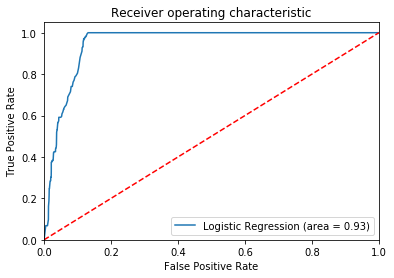

In [67]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y01_test, bestlogreg.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, bestlogreg.predict_proba(x01_test)[:,1],pos_label='1')
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Save the model as PMML File

In [ ]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(bestlogreg, 'LifePolicyLapseModel.pmml') 

### Run the model on entire dataset and save the output in a csv file

In [ ]:
# Copy the original data set
df_test = df_orig.copy()

In [ ]:
# Separate features into categorical and numerical category
cat_vars = ['POLICY_STATUS', 'FEMALE', 'MALE', 'GENDER_UNKNOWN', 'MARRIED', 'DIVORCED',
           'SINGLE', 'MARITAL_STATUS_UNKNOWN', 'PROFESSION', 'CHILD', 'YOUTH', 'ADULT', 'SENIOR_CITIZEN', 'NON_SMOKER',
           'SMOKER', 'UNDER_WEIGHT', 'NORMAL_WEIGHT', 'OVER_WEIGHT', 'OBESE']

num_vars = ['Q1_BUY', 'Q2_BUY', 'Q3_BUY']  

In [ ]:
# Convert to 'category' object type
for var in cat_vars:
    df_test[var] = df_test[var].astype('category')

In [ ]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_test[var], prefix=var)
    dummy_data = df_test.join(cat_list)
    df_test = dummy_data

In [ ]:
# Remove original columns for which dummy variables have been created
vars_remove = ['POLICY_NUMBER','CLIENT_NUMBER','POLICY_STATUS', 'FEMALE', 'MALE', 'GENDER_UNKNOWN',
               'MARRIED', 'DIVORCED','SINGLE', 'MARITAL_STATUS_UNKNOWN', 'PROFESSION', 'CHILD', 'YOUTH', 'ADULT', 
               'SENIOR_CITIZEN', 'NON_SMOKER', 'SMOKER', 'UNDER_WEIGHT', 'NORMAL_WEIGHT', 'OVER_WEIGHT', 'OBESE',
               'LAPSE_INDICATOR']

for var in vars_remove:
    df_test=df_test.drop(var, axis=1)

In [ ]:
# Get selective features same as used in training
top_features = ['POLICY_STATUS_In Force-IF', 'POLICY_STATUS_Not Taken Up-NT', 'Q1_BUY', 'NORMAL_WEIGHT_0',
               'POLICY_STATUS_Approved Death Claim-DH',  'POLICY_STATUS_Cancelled from Inception-CF',
               'Q3_BUY','UNDER_WEIGHT_1', 'NORMAL_WEIGHT_1']

In [ ]:
# Retain only top features in the datframe
df_test=df_test[top_features]

In [ ]:
# Make predictions
prediction_class = bestlogreg.predict(df_test)
prediction_prob = bestlogreg.predict_proba(df_test)

# Get Individual Probabilities
not_lapse, lapse = (prediction_prob).T

In [ ]:
# Save original dataframe in a separate dataframe
df_results = df_orig.copy()

In [ ]:
# Remove target column
df_results=df_results.drop('LAPSE_INDICATOR',axis=1)

In [ ]:
# Replace target column with predicted value of '0' or '1' along with respective probablities
df_results['notlapse'] = not_lapse
df_results['lapse'] = lapse
df_results['lapse_prediction_class'] = prediction_class

### Though care has been taken in testing the query output, still double check for duplicate rows for a policy in the csv file

In [ ]:
df_results.to_csv('EX_SOURCE_POLICY_LAPSE_LIFE.csv', index = None, header=True) 